In [94]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [134]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sn

import warnings
warnings.filterwarnings("ignore")

In [158]:
data=pd.read_csv('final_df.csv')

In [159]:
data = data.drop([ 'clean_text', 'tokenized_clean_text','tokenized_stem_text', 'token_length',], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3963 entries, 0 to 3962
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Speech  3962 non-null   object
 1   Label   3963 non-null   int64 
 2   text    3960 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.0+ KB


In [160]:
data.fillna(0)


,Speech,Label,text
0,সমুচা আরেকটু বেশি দরকার,2,সমুচা আরেকটু দরক
1,"বাসাবোর কাবাবিস,কাবাব মে হাড্ডি, কাবাব স্টেশন ...",1,বাসাবোর কাবাব কাবাব মে হাড্ডি কাবাব স্টেশন ভালো
2,রোস্ট এভারেজ,2,রোস্ট এভারেজ
3,মাছের তরকারি আর আরেক্টু বাড়ালে জমতো,2,মাছ তরকারি আরেক্টু বাড়ালে জম
4,রোস্ট আহামরি কিছু না,2,রোস্ট আহামরি না
...,...,...,...
3958,খাবারের মান ভালো তবে পরিমাণ কম,2,খাবারের মান ভালো পরিমাণ কম
3959,রোস্ট মোটামটি ভালো,2,রোস্ট মোটাম ভালো
3960,কাচ্চি আরও রান্না হলে ভালো হতো,2,কাচ্চি রান্না ভালো হত
3961,সমুচা খুবই বাজে,0,সমুচা খুব বাজে


In [161]:
data.Label.value_counts()   #balanced dataset

2    1751
1    1108
0    1104
Name: Label, dtype: int64

In [162]:
data['text'] = data['text'].str.replace(r'\s+', ' ')

In [163]:
data.text[2]

'রোস্ট এভারেজ'

## Word Frequency for each class 

### (WORDCLOUD VISUALIZATION)

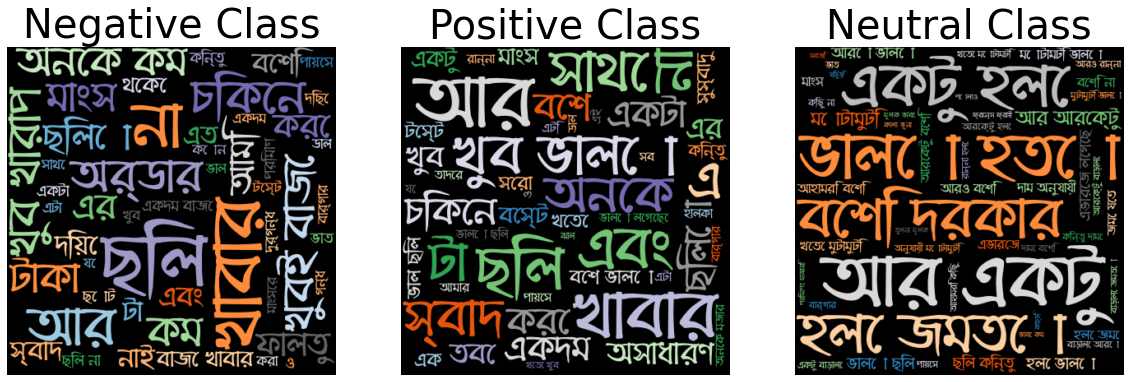

In [173]:
#wordcloud to see importance of word for each label
from wordcloud import WordCloud
df = data
df.Speech=df.Speech.apply(str)

regex = r"[\u0980-\u09FF]+"

# Start with one review:
df_Negative = df[df['Label']==0]
df_Positive = df[df['Label']==1]
df_Neutral = df[df['Label']==2]

text_Neg = " ".join(review for review in df_Negative.Speech)
text_Pos = " ".join(review for review in df_Positive.Speech)
text_Neu = " ".join(review for review in df_Neutral.Speech)

fig, (ax1, ax2, ax3) = plt.subplots( 1, 3 , figsize  = (20,20))
# Create and generate a word cloud image:
wordcloud_Neg = WordCloud(font_path="fonts/BenSenHandwriting.ttf",height=400,max_words=50,colormap='tab20c',collocations=True,max_font_size=100,regexp=regex).generate(text_Neg)
wordcloud_Pos = WordCloud(font_path="fonts/BenSenHandwriting.ttf",height=400,max_words=50,colormap='tab20c',collocations=True,max_font_size=100,regexp=regex).generate(text_Pos)
wordcloud_Neu = WordCloud(font_path="fonts/BenSenHandwriting.ttf",height=400,max_words=50,colormap='tab20c',collocations=True,max_font_size=100,regexp=regex).generate(text_Neu)


# Display the generated image:
ax1.imshow(wordcloud_Neg, interpolation='bilinear')
ax1.set_title('Negative Class',fontsize=40)
ax1.axis('off')

ax2.imshow(wordcloud_Pos, interpolation='bilinear')
ax2.set_title('Positive Class',fontsize=40)
ax2.axis('off')

ax3.imshow(wordcloud_Neu, interpolation='bilinear')
ax3.set_title('Neutral Class',fontsize=40)
ax3.axis('off');



## Data Split 

## (Training : 80% and Testing 20% )

In [102]:
data.text =  data.text.apply(str)

X = data['text']
Y = data['Label']

In [103]:
data.text =  data.text.apply(str)
X = data['text']
Y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(3170,)
(793,)
(3170,)
(793,)


In [104]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


In [105]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


## Model Development 

### Pipeline creation using TFIDF, One VS rest classifier and several ML models

### Multinomial Naive Bayes

In [106]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.naive_bayes import MultinomialNB
TFIDF_NB_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=2000, min_df=1,ngram_range=(1,2))),
                
                ('clf', OneVsRestClassifier(MultinomialNB(
                    alpha=0.15,fit_prior=True, class_prior=None))),
            ])

TFIDF_NB_pipeline.fit(X_train, y_train)
TFIDF_NB_pipeline_prediction = TFIDF_NB_pipeline.predict(X_test)


print('accuracy %s' % accuracy_score(TFIDF_NB_pipeline_prediction, y_test))

accuracy 0.8902900378310215


### SGD Classifier

In [107]:
from sklearn.linear_model import SGDClassifier
TFIDF_SGD_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=13000,min_df=1,ngram_range=(1,2))),
                ('clf',OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=100, tol=None)))
            ])

TFIDF_SGD_pipeline.fit(X_train, y_train)
TFIDF_SGD_pipeline_prediction = TFIDF_SGD_pipeline.predict(X_test)


print('accuracy %s' % accuracy_score(TFIDF_SGD_pipeline_prediction, y_test))

accuracy 0.9306431273644389


### Logistric Regeression

In [108]:
from sklearn.linear_model import LogisticRegression
TFIDF_LR_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=5000,min_df=4,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(multi_class='ovr',solver='liblinear',C=1,random_state=42,tol=0.0001,max_iter=300)))
            ])

TFIDF_LR_pipeline.fit(X_train, y_train)
TFIDF_LR_pipeline_prediction = TFIDF_LR_pipeline.predict(X_test)


print('accuracy %s' % accuracy_score(TFIDF_LR_pipeline_prediction, y_test))

accuracy 0.9155107187894073


### Random Forest Classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier
TFIDF_RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=11000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=500,criterion ='entropy')))
            ])


TFIDF_RF_pipeline.fit(X_train, y_train)
TFIDF_RF_pipeline_prediction = TFIDF_RF_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_RF_pipeline_prediction, y_test))

accuracy 0.9041614123581336


### XGBClassifier

In [110]:
import xgboost as xgb
TFIDF_XGB_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=10000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(xgb.XGBClassifier(n_jobs=1)))
            ])


TFIDF_XGB_pipeline.fit(X_train, y_train)
TFIDF_XGB_pipeline_prediction = TFIDF_XGB_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_XGB_pipeline_prediction, y_test))

[15:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy 0.9003783102143758


### SVC (kernel = linear) 

In [111]:
# svc linear kernel
from sklearn.svm import SVC
TFIDF_SVC_linear_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=13000,min_df=3,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SVC(random_state=42,kernel='linear')))
            ])


TFIDF_SVC_linear_pipeline.fit(X_train, y_train)
TFIDF_SVC_linear_pipeline_prediction = TFIDF_SVC_linear_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_SVC_linear_pipeline_prediction, y_test))


accuracy 0.9218158890290038


### Decision Tree Classifier

In [112]:
from sklearn.tree import DecisionTreeClassifier
TFIDF_DT_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=13000,min_df=3,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(DecisionTreeClassifier(random_state=43, max_depth=71)))
            ])


TFIDF_DT_pipeline.fit(X_train, y_train)
TFIDF_DT_pipeline_prediction = TFIDF_DT_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_DT_pipeline_prediction, y_test))


accuracy 0.8524590163934426


### KNeighbors Classifier

In [113]:
from sklearn.neighbors import KNeighborsClassifier
TFIDF_NearestNeighbors_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=2,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=25)))
            ])


TFIDF_NearestNeighbors_pipeline.fit(X_train, y_train)
TFIDF_NearestNeighbors_pipeline_prediction = TFIDF_NearestNeighbors_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_NearestNeighbors_pipeline_prediction, y_test))


accuracy 0.8890290037831021


### SVC (kernel = rbf) 

In [114]:
#RB SVM
from sklearn.svm import SVC
TFIDF_svc_rbf_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=2,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SVC(random_state=42, kernel='rbf')))
            ])


TFIDF_svc_rbf_pipeline.fit(X_train, y_train)
TFIDF_svc_rbf_pipeline_prediction = TFIDF_svc_rbf_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_svc_rbf_pipeline_prediction, y_test))

accuracy 0.9230769230769231


### Passive Aggressive Classifier

In [115]:
#RB PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
TFIDF_PassiveAggressive_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(PassiveAggressiveClassifier(random_state=42,max_iter=500,tol=None)))
            ])


TFIDF_PassiveAggressive_pipeline.fit(X_train, y_train)
TFIDF_PassiveAggressive_pipeline_prediction = TFIDF_PassiveAggressive_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_PassiveAggressive_pipeline_prediction, y_test))

accuracy 0.9230769230769231


## AdaBoost Classifier

In [116]:
#AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

TFIDF_ada_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)))
            ])


TFIDF_ada_pipeline.fit(X_train, y_train)
TFIDF_ada_pipeline_prediction = TFIDF_ada_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_ada_pipeline_prediction, y_test))

accuracy 0.8978562421185372


### Bagging Classifier

In [117]:
#BaggingClassifier
from sklearn.ensemble import BaggingClassifier
TFIDF_Bagging_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=8000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=42)))
            ])


TFIDF_Bagging_pipeline.fit(X_train, y_train)
TFIDF_Bagging_pipeline_prediction = TFIDF_Bagging_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_Bagging_pipeline_prediction, y_test))

accuracy 0.9255989911727617


### Gradient Boosting Classifier

In [118]:
 #GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
TFIDF_GB_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42)))
            ])


TFIDF_GB_pipeline.fit(X_train, y_train)
TFIDF_GB_pipeline_prediction = TFIDF_GB_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_GB_pipeline_prediction, y_test))

accuracy 0.8776796973518285


### ExtraTrees Classifier

In [119]:
#ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
TFIDF_EXT_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=1,ngram_range=(1,2))),
                ('clf', ExtraTreesClassifier(n_estimators=100, random_state=42))
            ])


TFIDF_EXT_pipeline.fit(X_train, y_train)
TFIDF_EXT_pipeline_prediction = TFIDF_EXT_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_EXT_pipeline_prediction, y_test))

accuracy 0.9003783102143758


## Result Evaluation

In [120]:
from sklearn.metrics import *
MLA = {
    'MNB' : TFIDF_NB_pipeline,
    'SGD' : TFIDF_SGD_pipeline,
    'LR' : TFIDF_LR_pipeline,
    'RF' : TFIDF_RF_pipeline,
    'XGB' : TFIDF_XGB_pipeline,
    'SVC-linear' : TFIDF_SVC_linear_pipeline,
    'DT' : TFIDF_DT_pipeline,
    'KNN' : TFIDF_NearestNeighbors_pipeline,
    'SVC-rbf' : TFIDF_svc_rbf_pipeline,
    'PAG' : TFIDF_PassiveAggressive_pipeline,
    'ADB' : TFIDF_ada_pipeline,
    'BAG' : TFIDF_Bagging_pipeline,
    'GRB' : TFIDF_GB_pipeline,
    'EXT' : TFIDF_EXT_pipeline  
}

columns = []
compare = pd.DataFrame(columns = columns)
fpr = {}
tpr = {}
thresh ={}
n_class = 3


row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    predicted = alg.predict(X_test)
    micro_averaged_recall = recall_score(y_test, predicted, average = 'micro')
    macro_averaged_f1 = f1_score(y_test, predicted, average = 'macro')
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    compare.loc[row_index, 'Precision'] = precision_score(y_test, predicted, average = 'micro')
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = macro_averaged_f1
    row_index+=1
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare

,Name,Test Accuracy,Precision,Recall,F1 Score
1,SGD,0.9306,0.930643,0.930643,0.927496
11,BAG,0.9256,0.925599,0.925599,0.920990
8,SVC-rbf,0.9231,0.923077,0.923077,0.918636
9,PAG,0.9231,0.923077,0.923077,0.918833
5,SVC-linear,0.9218,0.921816,0.921816,0.917250
2,LR,0.9155,0.915511,0.915511,0.910301
3,RF,0.9042,0.904161,0.904161,0.898946
4,XGB,0.9004,0.900378,0.900378,0.893577
13,EXT,0.9004,0.900378,0.900378,0.893562
10,ADB,0.8979,0.897856,0.897856,0.891712


### ROC-Curve

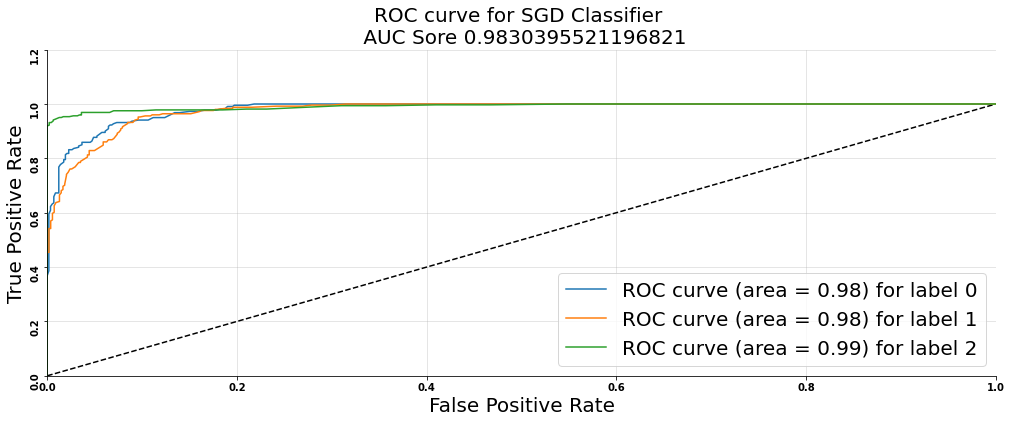

In [121]:
def plot_multiclass_roc(name, clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = TFIDF_EXT_pipeline.predict_proba(X_test)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    AUC = roc_auc_score(y_test, y_score, multi_class='ovo', average='weighted')
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.2])
    ax.set_xlabel('False Positive Rate',fontsize=20)
    ax.set_ylabel('True Positive Rate',fontsize=20)
    plt.xticks( rotation=0, weight = 'bold')
    plt.yticks( rotation=90, weight = 'bold')
    ax.set_title('ROC curve for {} \n AUC Sore {}'.format(name, AUC ),fontsize=20)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best",prop={'size': 20})
    ax.grid(alpha=.4)
    sns.despine()
plot_multiclass_roc('SGD Classifier', TFIDF_SGD_pipeline, X_test, y_test,n_class)

### Performance Comparison of Every Model

In [122]:
#plot performance comaparison 
def compare_plots(y_value,score):
  plt.subplots(figsize=(15,8))
  # color_palette("vlag", as_cmap=True)
  sn.barplot(x="Name", y=y_value,palette='icefire',data=compare,edgecolor=sn.color_palette('dark',7))
  
  plt.tick_params(axis='x',rotation=90,labelsize=22)
  plt.tick_params(axis='y',rotation=0,labelsize=18)
  plt.title('Comparing performance with '+y_value+'.', fontsize=20)
  plt.ylabel(score +' Score', fontsize=22)
  plt.xlabel('Machine Learning Algorithms', fontsize=16)
  plt.show()
  return plt


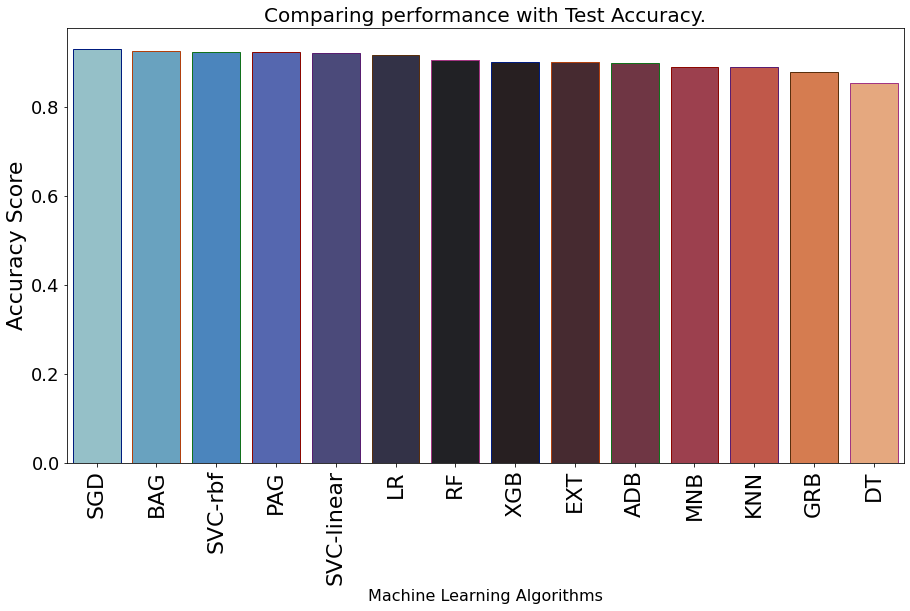

In [123]:
# Performance conparion with respect to Accuracy
compare_plots('Test Accuracy', 'Accuracy');

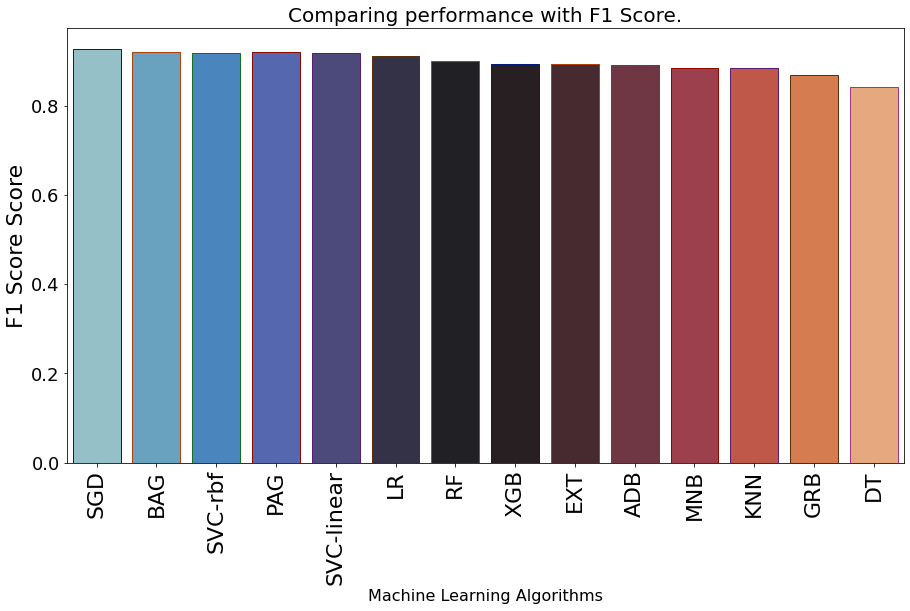

In [124]:
# Performance conparion with respect to F1 score
compare_plots('F1 Score', 'F1 Score');

## Model Validation 

### Confusion Matrix

In [125]:
def conf_matrix(pred,classfier):
  predictions = pred
  y_pred = np.array(predictions)
  cm = confusion_matrix(y_test, y_pred) 

  cm_df = pd.DataFrame(cm,
                       index = ['negative', 'positive', 'neutral'], 
                       columns = ['negative', 'positive', 'neutral'])
  plt.figure(figsize=(5,5))
  sn.heatmap(cm_df, annot=True,cmap="BuPu", fmt='g')
  plt.title('\n'+classfier+' Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
  plt.ylabel('True label',weight = 'bold',fontsize=10)
  plt.xlabel('Predicted label', weight = 'bold',fontsize=10)
  plt.tick_params(rotation=0,axis='y', labelsize=14)
  plt.tick_params(rotation=0,axis='x', labelsize=14)
  plt.xticks(rotation = 0)
  plt.yticks(rotation = 90)

  plt.show()
  plt.close()



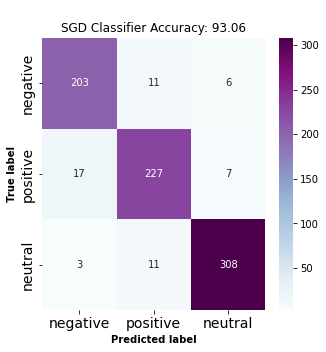

In [126]:
## Confusion Matric of SGD classifier (best perfomed model)
conf_matrix(TFIDF_SGD_pipeline_prediction, 'SGD Classifier')

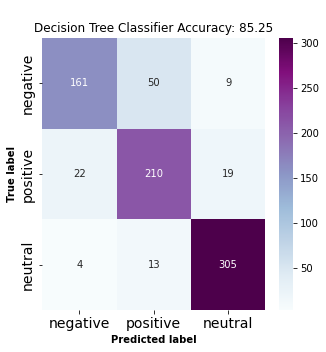

In [127]:
## Confusion Matric of Decision Tree (lowest perfomed model)
conf_matrix(TFIDF_DT_pipeline_prediction, 'Decision Tree Classifier')

### Learning Curve

In [93]:
data.text =  data.text.apply(str)
X = data['text']
Y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.0001, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3962,)
(1,)
(3962,)
(1,)


In [87]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


In [92]:
from sklearn.model_selection import StratifiedKFold,cross_val_score,learning_curve

def learn_curve(pipeline, X,y):
    lr = pipeline    
    
    cv = StratifiedKFold(n_splits=15,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

In [89]:
learning_SGD_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=9000,min_df=2,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SVC(random_state=42, kernel='rbf')))
            ])
lc=learn_curve(learning_SGD_pipeline, X_train, y_train)

In [90]:
learn_curve(learning_SGD_pipeline, X_train, y_train)

{'cv_scores': array([0.95075758, 0.94318182, 0.92424242, 0.91666667, 0.93939394,
        0.9469697 , 0.90151515, 0.92045455, 0.95454545, 0.9469697 ,
        0.89393939, 0.92045455, 0.93181818, 0.93181818, 0.91634981]),
 'train_score': 0.9962111644354635,
 'learning_curve':    Training_size         variable     value
 0            369    Training_loss  0.000000
 1           1200    Training_loss  0.004611
 2           2032    Training_loss  0.004692
 3           2863    Training_loss  0.003865
 4           3695    Training_loss  0.003915
 5            369  Validation_loss  0.129086
 6           1200  Validation_loss  0.084872
 7           2032  Validation_loss  0.078306
 8           2863  Validation_loss  0.071488
 9           3695  Validation_loss  0.070728}

<AxesSubplot:xlabel='Training_size', ylabel='value'>

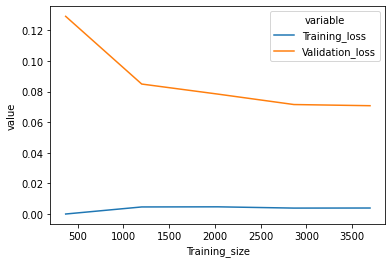

In [91]:
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")